In [2]:
import numpy as np
import librosa.display, os
import time
from torch import nn, optim
import torch
from torchsummary import summary
import os
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torchvision import transforms,datasets

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device {device}")

Using device cpu


In [27]:
def resample_audio(signal, sr, sampled_sr= 44100):
        if sr != sampled_sr:
            signal_resampled = librosa.resample(signal, orig_sr=sr, target_sr=sampled_sr)
            return signal_resampled, sampled_sr
        return signal, sr

def process_audio_duration(signal, sr, target_duration=5):
    # Make sure all audio are 5s
    target_samples = int(target_duration * sr)
    current_samples = len(signal)
    
    if current_samples > target_samples:
        signal = signal[:target_samples]
    
    # If the audio is shorter, pad with zeros (silence) to the target duration
    elif current_samples < target_samples:
        pad_length = target_samples - current_samples
        signal = np.pad(signal, (0, pad_length), mode='constant')
    
    return signal

def melspec_normalization(log_ms):
    # Normalize to [0, 1]
    return (log_ms - log_ms.min()) / (log_ms.max() - log_ms.min())
    
def load_audio(audio_file):
    y, sr = librosa.load(audio_file)
    y, sr = resample_audio(y, sr)
    # TO DO: should we add this?  reduce accuracy but looks better to compare spectrogram
    #y = process_audio_duration(y,sr)
    y = librosa.util.normalize(y)
    return y,sr
    
def create_mel_spectrogram(audio_file):
    y, sr = load_audio(audio_file)
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    log_ms = melspec_normalization(log_ms)
    return log_ms, sr


def create_mel_spectrogram_image(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    log_ms, sr = create_mel_spectrogram(audio_file)

    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close(fig)

    
    
def create_pngs_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dir = os.listdir(input_path)

    for i, file in enumerate(dir):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.wav', '.png'))
        create_mel_spectrogram_image(input_file, output_file)



/opt/anaconda3/envs/dl_course/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  return f(*args, **kwargs)
/opt/anaconda3/envs/dl_course/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  return f(*args, **kwargs)


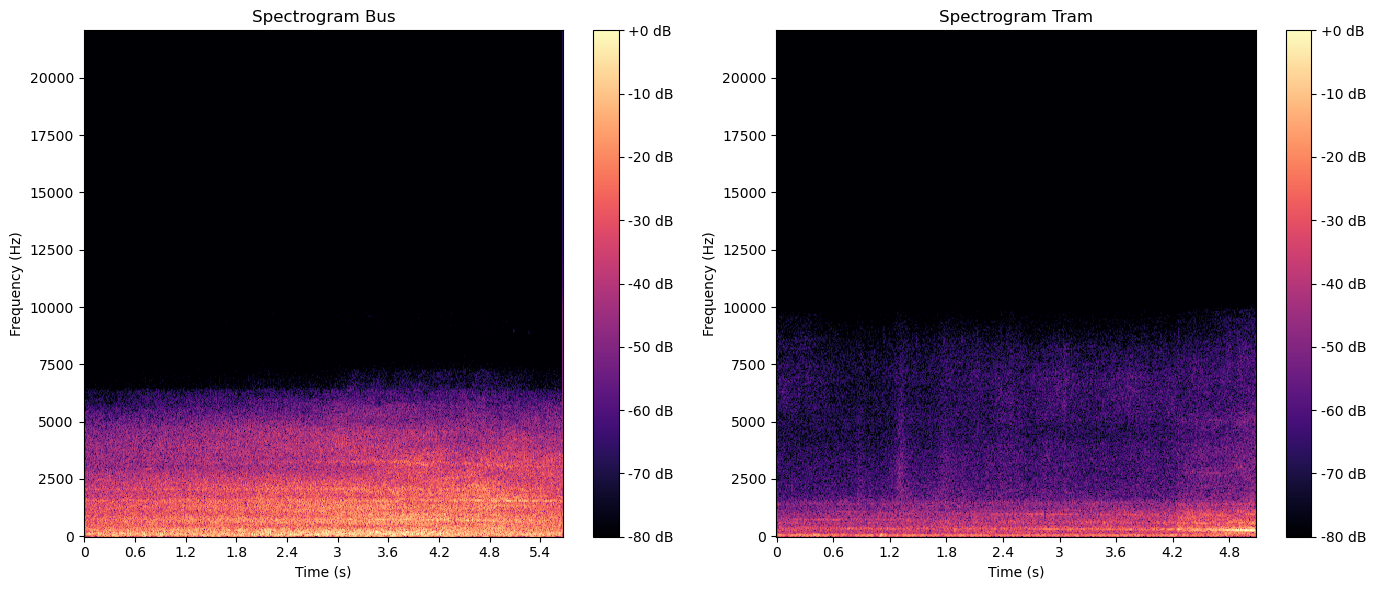

In [28]:
# Plot some spectrogram and compare
def create_spectrogram(audio_file):
    y, sr = load_audio(audio_file)
    n_fft = 1024
    win_length = n_fft
    hop_length = n_fft//2
    librosa_spectrogram = librosa.stft(y=y,n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    librosa_power_spectrogram = librosa.amplitude_to_db(librosa_spectrogram, ref=np.max)
    return librosa_power_spectrogram, sr


librosa_power_spectrogram1,sr1 = create_spectrogram('./dataset/bus/657981__petrijuhani__bussi2.wav')
librosa_power_spectrogram2,sr2 = create_spectrogram('./dataset/tram/709545__masa_ite__tram_hervannan_kampus_b_2.wav')

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
librosa.display.specshow(librosa_power_spectrogram1, sr=sr1, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Bus')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

plt.subplot(1, 2, 2)
librosa.display.specshow(librosa_power_spectrogram2, sr=sr2, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Tram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

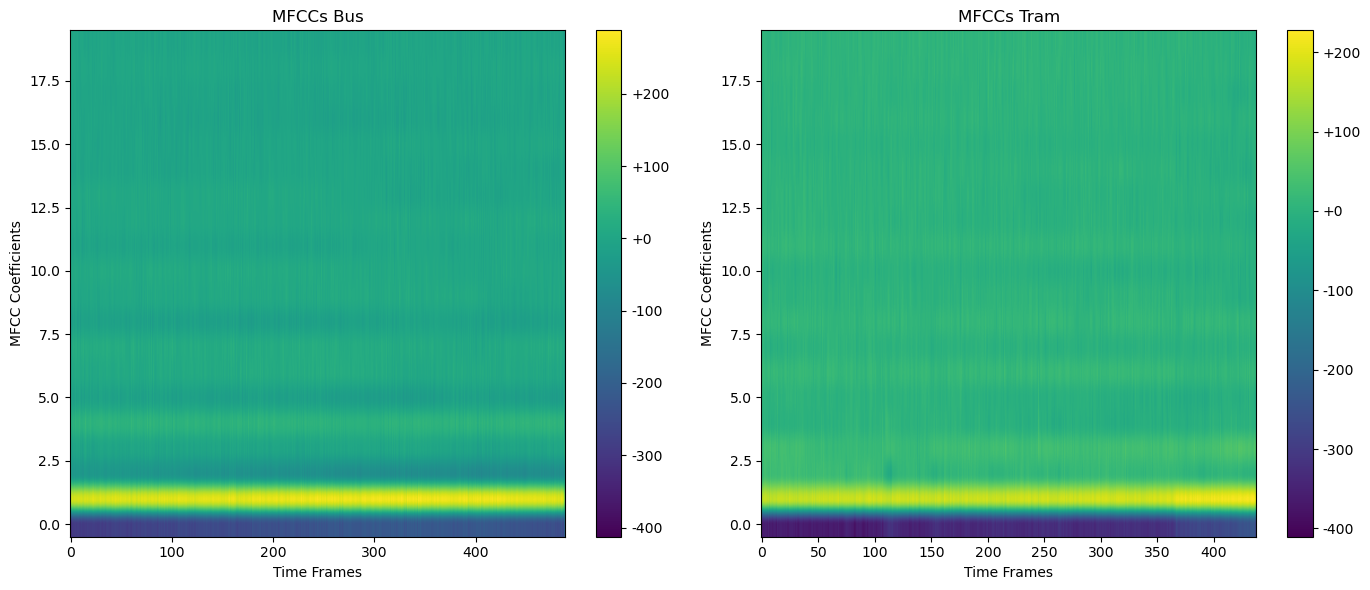

In [29]:
#Plot some mfccs and compare
def create_mfcc(audio_file):
    y, sr = load_audio(audio_file)
    n_fft = 1024
    hop_length =n_fft//2 
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    return mfccs

mfccs1 = create_mfcc('./dataset/bus/657981__petrijuhani__bussi2.wav')
mfccs2 = create_mfcc('./dataset/tram/709545__masa_ite__tram_hervannan_kampus_b_2.wav')


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(mfccs1, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f')
plt.title("MFCCs Bus")
plt.xlabel("Time Frames")
plt.ylabel("MFCC Coefficients")

plt.subplot(1, 2, 2)
plt.imshow(mfccs2, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f')
plt.title("MFCCs Tram")
plt.xlabel("Time Frames")
plt.ylabel("MFCC Coefficients")

plt.tight_layout()
plt.show()

In [30]:
create_pngs_from_wavs('./dataset/bus', './Spectogram_images/bus')
create_pngs_from_wavs('./dataset/tram', './Spectogram_images/tram')


In [31]:
def load_images_from_path(path):
    #transforms.ToTensor() automatically converts and normalizes pixel values to [0.0, 1.0]
    transformation = transforms.Compose([
        transforms.Resize((224, 224)),
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = datasets.ImageFolder(
        root=path,
        transform=transformation
    )

    return full_dataset

In [32]:
full_dataset = load_images_from_path('./Spectogram_images')

In [33]:
#split 70% train 30% test
train_size = int(0.7 * len(full_dataset))
test_size = len(full_dataset) - train_size

In [34]:
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True
    )
    
# define a loader for the testing data we can iterate through in 50-image batches
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
)

print(f'Training set size: {len(train_loader.dataset)}')
print(f'Testing set size: {len(test_loader.dataset)}')

Training set size: 224
Testing set size: 96


In [35]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), #(224+2×1−3)/1 +1 = (32, 224,224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Reduces dimensions by half (32, 112,112)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # (112+2×1−3)/1 +1 = (64, 112,112)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Reduces dimensions by half (64, 56,56)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), # (56+2×1−3)/1 +1 = (128, 56,56)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Reduces dimensions by half (128, 28,28)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1), # (28+2×1−3)/1 +1 = (128, 28,28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Reduces dimensions by half (128, 14,14)
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=128*14*14, out_features=1024)
        self.dropout = nn.Dropout(p=0.2)
        # dropout: Reduces overfitting, Improves generalization.
        self.fc2 = nn.Linear(in_features=1024, out_features=1)
        self.output = nn.Sigmoid()

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)  # Flatten feature maps into a 1D vector
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x) 
        x = self.output(x)  # Apply Sigmoid for binary classification
        
        return x
model=CNNModel().to(device)
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
              ReLU-8          [-1, 128, 56, 56]               0
         MaxPool2d-9          [-1, 128, 28, 28]               0
           Conv2d-10          [-1, 128, 28, 28]         147,584
             ReLU-11          [-1, 128, 28, 28]               0
        MaxPool2d-12          [-1, 128, 14, 14]               0
          Flatten-13                [-1, 25088]               0
           Linear-14                 [-

In [37]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total_samples = 0
    print("Epoch:", epoch)
    for batch_idx, (data, target) in enumerate(train_loader):
        # Converted to float32 with shape [batch_size, 1]
        data, target = data.to(device), target.to(device).float().unsqueeze(1)
        
        optimizer.zero_grad()
        
        output = model(data)
        
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()

        # Backpropagate
        loss.backward()
        optimizer.step()

        predicted = (output >= 0.5).float()
        correct += torch.sum(target == predicted).item()
        total_samples += target.size(0)
        
        # Print metrics so we see some progress
        print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
    # return accuracy for training
    accuracy = 100. * correct / total_samples
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss,accuracy

In [38]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device).float().unsqueeze(1)
            
            output = model(data)
            
            test_loss += loss_criteria(output, target).item()
            
            predicted = (output >= 0.5).float()
            correct += torch.sum(target == predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    accuracy = 100. * correct / len(test_loader.dataset)
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        accuracy))
    
    # return average loss for the epoch
    return avg_loss,accuracy

In [39]:
# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria (use BCE here for Binary Classification)
loss_criteria = nn.BCELoss()

# Track metrics in these arrays
epoch_nums = []
epoch_loss = []
epoch_validation_loss = []

epoch_training_accuracy = []
epoch_validation_accuracy = []

epochs = 10
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
        test_loss, test_accuracy = test(model, device, test_loader)
        epoch_nums.append(epoch)
        epoch_loss.append(train_loss)
        epoch_validation_loss.append(test_loss)
        epoch_training_accuracy.append(train_accuracy)
        epoch_validation_accuracy.append(test_accuracy)

Training on cpu
Epoch: 1
	Training batch 1 Loss: 0.692124
	Training batch 2 Loss: 4.416628
	Training batch 3 Loss: 0.827817
	Training batch 4 Loss: 0.860575
	Training batch 5 Loss: 0.696242
	Training batch 6 Loss: 0.703082
	Training batch 7 Loss: 0.771419
Training set: Average loss: 1.281127
Validation set: Average loss: 0.685829, Accuracy: 63/96 (66%)

Epoch: 2
	Training batch 1 Loss: 0.683825
	Training batch 2 Loss: 0.702730
	Training batch 3 Loss: 0.694760
	Training batch 4 Loss: 0.705251
	Training batch 5 Loss: 0.682356
	Training batch 6 Loss: 0.671023
	Training batch 7 Loss: 0.673315
Training set: Average loss: 0.687609
Validation set: Average loss: 0.673726, Accuracy: 50/96 (52%)

Epoch: 3
	Training batch 1 Loss: 0.677736
	Training batch 2 Loss: 0.652581
	Training batch 3 Loss: 0.658110
	Training batch 4 Loss: 0.637966
	Training batch 5 Loss: 0.634746
	Training batch 6 Loss: 0.638664
	Training batch 7 Loss: 0.589450
Training set: Average loss: 0.641322
Validation set: Average los

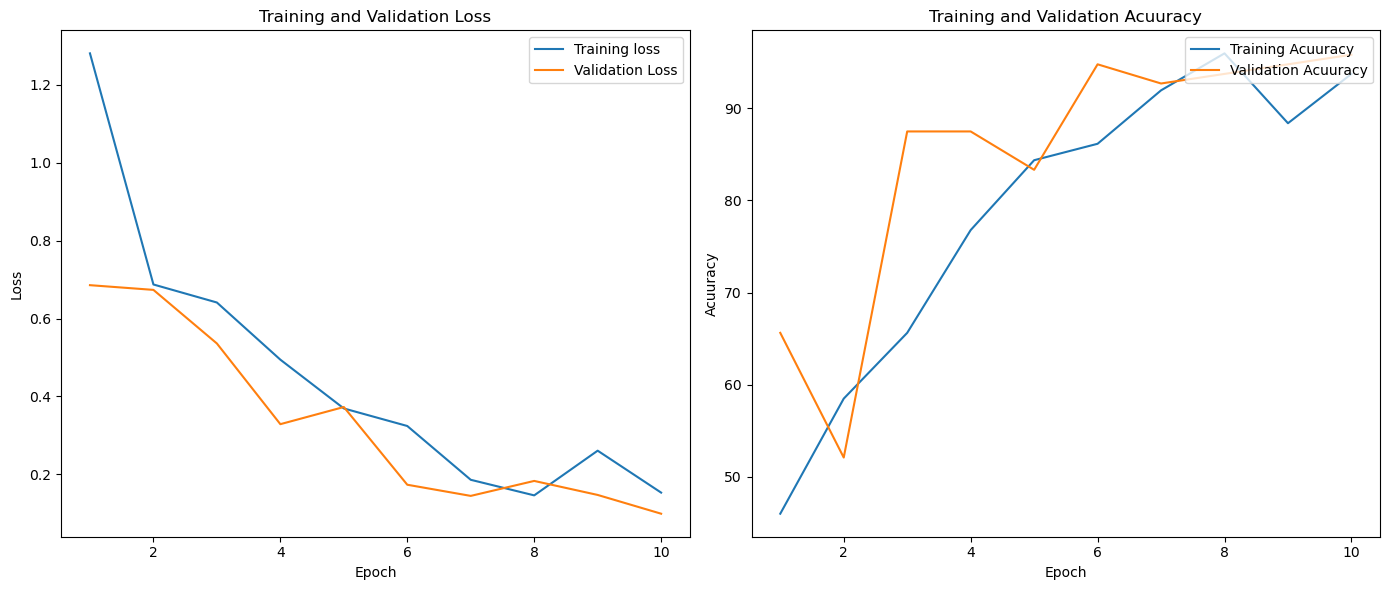

In [40]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epoch_nums, epoch_loss)
plt.plot(epoch_nums, epoch_validation_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation Loss'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(epoch_nums, epoch_training_accuracy)
plt.plot(epoch_nums, epoch_validation_accuracy)
plt.title('Training and Validation Acuuracy')
plt.xlabel('Epoch')
plt.ylabel('Acuuracy')
plt.legend(['Training Acuuracy', 'Validation Acuuracy'], loc='upper right')

plt.tight_layout()
plt.show()

In [41]:
torch.save(model.state_dict(), 'vehicle-audio-processing-model.pth')

In [42]:
# Test with audio not in datasets
audo_test_folder="./test_audio"

#create Image for classification
create_pngs_from_wavs('./test_audio', './test_audio_mel_spectrogram')
image_folder = "./test_audio_mel_spectrogram"

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_labels = sorted(os.listdir('./Spectogram_images'))
print(classes) # ['bus', 'tram']

model = CNNModel()  # Replace with your actual model class
model.load_state_dict(torch.load("vehicle-audio-processing-model.pth", map_location=device, weights_only=False))
model.to(device)
model.eval() 

transform = transforms.Compose([
    transforms.Resize((224, 224)),                # Resize to match model input size
    transforms.ToTensor(),                        # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize (adjust if needed)
])


for filename in os.listdir(image_folder):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        image_path = os.path.join(image_folder, filename)

        # Load and preprocess the image
        img = Image.open(image_path).convert("RGB")
        x = transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Perform inference
        with torch.no_grad():
            output = model(x)
            probability = output.item()  # Get the probability for the positive class

        # Determine the predicted label
        predicted_label = class_labels[1] if probability >= 0.5 else class_labels[0]

        # Print the result
        print(f'File: {filename}, Predicted as: {predicted_label} (Probability: {probability:.4f})')

print("\nTesting completed.")

['bus', 'tram']
File: 664055__juusooo__bus-2.png, Predicted as: bus (Probability: 0.2279)
File: 664056__juusooo__bus-1.png, Predicted as: bus (Probability: 0.0673)
File: 664961__essss123__tram1.png, Predicted as: tram (Probability: 0.9950)
File: 664981__essss123__tram4.png, Predicted as: tram (Probability: 0.9991)
File: 664971__essss123__tram6.png, Predicted as: tram (Probability: 0.9986)
File: 664982__essss123__tram3.png, Predicted as: tram (Probability: 0.8146)
File: 664970__essss123__tram5.png, Predicted as: tram (Probability: 0.9932)
File: 664975__essss123__tram2.png, Predicted as: tram (Probability: 0.9078)

Testing completed.
